In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

In [2]:
# 1. Load the dataset
df = pd.read_csv("data/mushroom2.csv")

# 2. Fill the real-missing values with "?"
df = df.fillna("?")

# 3. Drop useless columns identified from EDA (gill-attachment, veil-type)
df = df.drop(columns=["veil-type"])

# 4. Separate features and target
X = df.drop("class", axis=1)
y = df["class"]

# 5. Perform 80–20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y)

In [3]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

### Preprocessing

In [4]:
categorical_features = X.columns.tolist()

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Column transformer that applies OHE to all features
preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, categorical_features)
    ]
)

pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
    ('svm', SVC(probability=True,
        class_weight="balanced",
        random_state=42)) 
])

### SVM GridSearch

In [5]:
param_grid = [
    # RBF Kernel (Test C and Gamma)
    {
        'svm__kernel': ['rbf'],
        'svm__C': [0.01, 0.1, 1, 10],
        'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]
    }
]

In [6]:
print("Starting Grid Search Optimizing AUC-ROC")
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,               # 5-Fold Cross Validation
    scoring="roc_auc", # You can change this to 'recall' if catching poison is priority
    n_jobs=-1,          # Use all available CPU cores
    verbose=3
)

grid_search.fit(X_train, y_train_enc)

Starting Grid Search Optimizing AUC-ROC
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 3/5] END svm__C=0.01, svm__gamma=scale, svm__kernel=rbf;, score=0.832 total time= 8.3min
[CV 1/5] END svm__C=0.01, svm__gamma=scale, svm__kernel=rbf;, score=0.821 total time= 8.3min
[CV 4/5] END svm__C=0.01, svm__gamma=scale, svm__kernel=rbf;, score=0.829 total time= 8.3min
[CV 5/5] END svm__C=0.01, svm__gamma=scale, svm__kernel=rbf;, score=0.834 total time= 8.4min
[CV 2/5] END svm__C=0.01, svm__gamma=scale, svm__kernel=rbf;, score=0.832 total time= 8.4min
[CV 1/5] END svm__C=0.01, svm__gamma=auto, svm__kernel=rbf;, score=0.813 total time= 8.4min
[CV 5/5] END svm__C=0.01, svm__gamma=auto, svm__kernel=rbf;, score=0.826 total time= 8.4min
[CV 3/5] END svm__C=0.01, svm__gamma=auto, svm__kernel=rbf;, score=0.823 total time= 8.4min
[CV 4/5] END svm__C=0.01, svm__gamma=auto, svm__kernel=rbf;, score=0.820 total time= 8.4min
[CV 2/5] END svm__C=0.01, svm__gamma=auto, svm__kernel=rbf;, scor

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'svm__C': [0.01, 0.1, ...], 'svm__gamma': ['scale', 'auto', ...], 'svm__kernel': ['rbf']}]"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,categories,'auto'


### Train best model on entire TRAIN

In [9]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(f'Best AUC-ROC from Grid Search: {best_score}')

{'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best AUC-ROC from Grid Search: 0.8374462715924975


In [16]:
pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
    ('svm', SVC(
        C=0.1, gamma=0.1, kernel = 'rbf',
        probability=True
    )) 
])

pipeline.fit(X_train, y_train_enc)


,steps,"[('encoder', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [24]:
y_proba_svm = pipeline.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_svm = np.where(y_proba_svm >= threshold, "p", "e")

print("SVM (RBF) Accuracy:", accuracy_score(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
TN, FP, FN, TP = cm_svm.ravel()
TPR = TP / (TP + FN)
FNR = FN / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)

print(f"\nTrue Positive Rate (TPR): {TPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")

print("\nSVM Confusion Matrix:")
print(cm_svm)

# Calculate F2 score
# ---- F2 SCORE HERE ----
F2 = fbeta_score(y_test, y_pred_svm, beta=2, pos_label="p")
print(f"\nF2 Score: {F2:.4f}")

SVM (RBF) Accuracy: 0.7185455944594075

True Positive Rate (TPR): 0.8689
False Negative Rate (FNR): 0.1311
False Positive Rate (FPR): 0.4033
True Negative Rate (TNR): 0.5967

SVM Confusion Matrix:
[[1713 1158]
 [ 305 2022]]

F2 Score: 0.8096



SVM ROC AUC: 0.8274


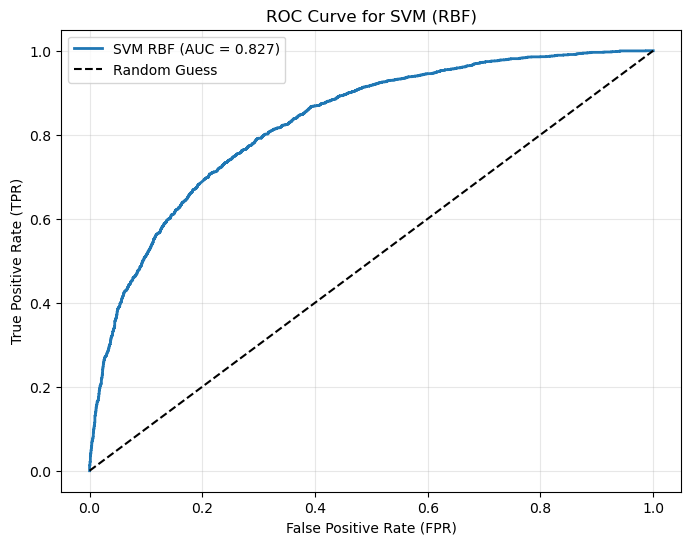

In [27]:
# Compute ROC curve & AUC score

y_proba_svm = pipeline.predict_proba(X_test)[:, 1]  # prob of class 'p'

fpr_svm, tpr_svm, _ = roc_curve(y_test.map({'e': 0, 'p': 1}), y_proba_svm)
auc_svm = auc(fpr_svm, tpr_svm)

print(f"\nSVM ROC AUC: {auc_svm:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM RBF (AUC = {auc_svm:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for SVM (RBF)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()